# Default training curves

In [1]:
import csv
import json

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

GW_SIZES = [2**i for i in range(5, 10)]

GWSIZE_GROUPED_AGENTTYPE_PERFS_FILENAMES_DICT = {
  gw_size: f"gw_agents_perfs/{gw_size}_gru_vs_gw.csv" for gw_size in GW_SIZES
}; GWSIZE_GROUPED_AGENTTYPE_PERFS_FILENAMES_DICT

gw_agenttype_success_metrics_dict = {}
for gw_size in GW_SIZES:
  filename = GWSIZE_GROUPED_AGENTTYPE_PERFS_FILENAMES_DICT[gw_size]

  with open(filename, 'r') as f:
    csv_reader = csv.reader(f)

    gw_agenttype_success_metrics_dict[gw_size] = list(csv_reader)

  # print(len(gw_agenttype_success_metrics_dict[gw_size]))

In [2]:
headers_row = gw_agenttype_success_metrics_dict[32][0]; headers_row
for cidx, header in enumerate(headers_row):
  # if header.endswith("metrics/success"):
  print(f"{cidx}: {header}")


0: global_step
1: agent_type: gru (SAVI BC Dataset_v0) - _step
2: agent_type: gru (SAVI BC Dataset_v0) - _step__MIN
3: agent_type: gru (SAVI BC Dataset_v0) - _step__MAX
4: agent_type: gru (SAVI BC Dataset_v0) - metrics/success
5: agent_type: gru (SAVI BC Dataset_v0) - metrics/success__MIN
6: agent_type: gru (SAVI BC Dataset_v0) - metrics/success__MAX
7: agent_type: gw (SAVI BC Dataset_v0) - _step
8: agent_type: gw (SAVI BC Dataset_v0) - _step__MIN
9: agent_type: gw (SAVI BC Dataset_v0) - _step__MAX
10: agent_type: gw (SAVI BC Dataset_v0) - metrics/success
11: agent_type: gw (SAVI BC Dataset_v0) - metrics/success__MIN
12: agent_type: gw (SAVI BC Dataset_v0) - metrics/success__MAX


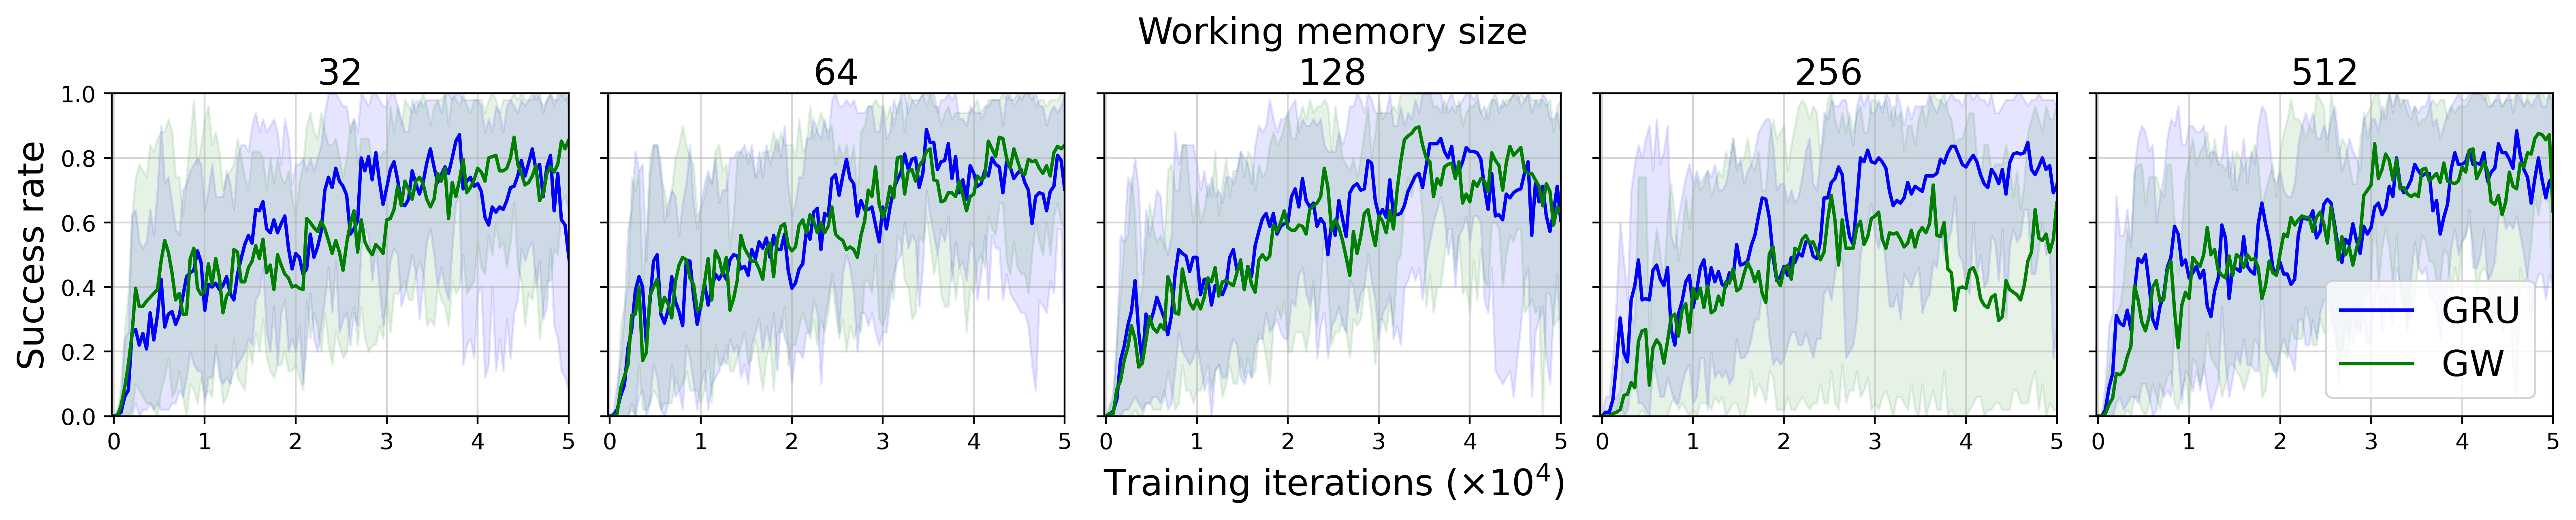

In [4]:
mpl.rcParams.update(mpl.rcParamsDefault)
MAX_STEP = 1301

sns_paired_palette = sns.color_palette("Paired")

fig, axes = plt.subplots(1, 5, figsize=(16, 3), dpi=400, sharey=True)

train_success_metric_data = gw_agenttype_success_metrics_dict[32]

EXPNAME_TO_CSV_CIDX = {
  "GRU": 4,
  "GW": 10,
}

EXPNAME_TO_COLOR = {
  "GRU": "blue",
  "GW": "green"
}

FONTSIZE = 16

# fig.show()
for cidx, (gw_size, success_metric_data) in enumerate(gw_agenttype_success_metrics_dict.items()):
  xs = [int(row[0]) for row in success_metric_data[1:MAX_STEP]]; len(xs)

  axes[cidx].xaxis.set_label_position("top")
  if cidx == 2:
    axes[cidx].set_xlabel(f"Working memory size\n{gw_size}", fontsize=FONTSIZE)
  else:
    axes[cidx].set_xlabel(gw_size, fontsize=FONTSIZE)
  
  # Holdes the list of success rates for each global step for each experiment variant
  EXPNAME_SCORE_LIST = {k: [] for k in EXPNAME_TO_CSV_CIDX.keys()}; EXPNAME_SCORE_LIST
  EXPNAME_SCORE_MIN_LIST = {k: [] for k in EXPNAME_TO_CSV_CIDX.keys()}; EXPNAME_SCORE_LIST
  EXPNAME_SCORE_MAX_LIST = {k: [] for k in EXPNAME_TO_CSV_CIDX.keys()}; EXPNAME_SCORE_LIST

  for row in success_metric_data[1:MAX_STEP]:
    for expname, exp_idx in EXPNAME_TO_CSV_CIDX.items():
      EXPNAME_SCORE_LIST[expname].append(float(row[exp_idx]))
      EXPNAME_SCORE_MIN_LIST[expname].append(float(row[exp_idx+1]))
      EXPNAME_SCORE_MAX_LIST[expname].append(float(row[exp_idx+2]))
  
  EXPNAME_SCORE_LIST = {k: np.array(v) for k, v in EXPNAME_SCORE_LIST.items()}
  EXPNAME_SCORE_MIN_LIST = {k: np.array(v) for k, v in EXPNAME_SCORE_MIN_LIST.items()}
  EXPNAME_SCORE_MAX_LIST = {k: np.array(v) for k, v in EXPNAME_SCORE_MAX_LIST.items()}

  # Check that the scores were properly extracted
  # for k, v in EXPNAME_SCORE_LIST.items():
  #   print(f"{k}: {len(v)}")

  SMTH = 10

  # print(EXPNAME_SCORE_LIST.keys())
  # print(json.dumps(EXPNAME_SCORE_LIST))
  # print(json.dumps(EXPNAME_SCORE_LIST, indent=2))

  for expname, exp_score_list in EXPNAME_SCORE_LIST.items():
    axes[cidx].plot(np.arange(0, len(xs), SMTH), 
                    exp_score_list.reshape(-1, SMTH).mean(axis=1).reshape(-1),
                    c=EXPNAME_TO_COLOR[expname], label=expname)
    
    axes[cidx].fill_between(
      np.arange(0, len(xs), SMTH),
      EXPNAME_SCORE_MIN_LIST[expname].reshape(-1, SMTH).mean(axis=1).reshape(-1),
      EXPNAME_SCORE_MAX_LIST[expname].reshape(-1, SMTH).mean(axis=1).reshape(-1),
      alpha=0.1,
      color=EXPNAME_TO_COLOR[expname]
    )

    tick_positions = np.arange(0, 1300 + 1, 250)  # Adjust the step size as needed

  axes[cidx].set_xlim([-5, 1250])
  axes[cidx].set_ylim([-0, 1.0])

  axes[cidx].set_xticks(tick_positions)
  x_tickslabels = [0, 1, 2, 3, 4, 5]
  axes[cidx].set_xticklabels(x_tickslabels)
  # break

axes[0].set_ylabel("Success rate", fontsize=FONTSIZE)
fig.text(0.5175, -0.035, "Training iterations ($ \\times 10^4$)", ha='center', fontsize=FONTSIZE)
axes[-1].legend(loc="lower right", fontsize=FONTSIZE)
for i in range(5):
  axes[i].grid(True, alpha=0.5, zorder=-10,)
fig.tight_layout()

fig.show()

fig.savefig("revised_analysis_plots/GRU_GW_SuccessRates_GW_Size_Grouped.pdf", bbox_inches="tight")